<a href="https://colab.research.google.com/github/rimabsg/ESPITA/blob/main/cancer_detection_(poumons).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

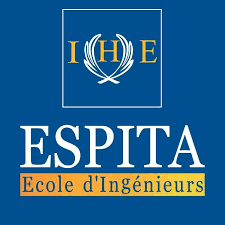

# **Préparation de l'Environnement**

In [ ]:
pip install numpy

In [ ]:
pip install pandas

In [ ]:
pip install tensorflow


In [ ]:
pip install matplotlib


In [ ]:
pip install seaborn

In [ ]:
pip install opencv-python #computer vision

# **Detection de cancer des poumons**

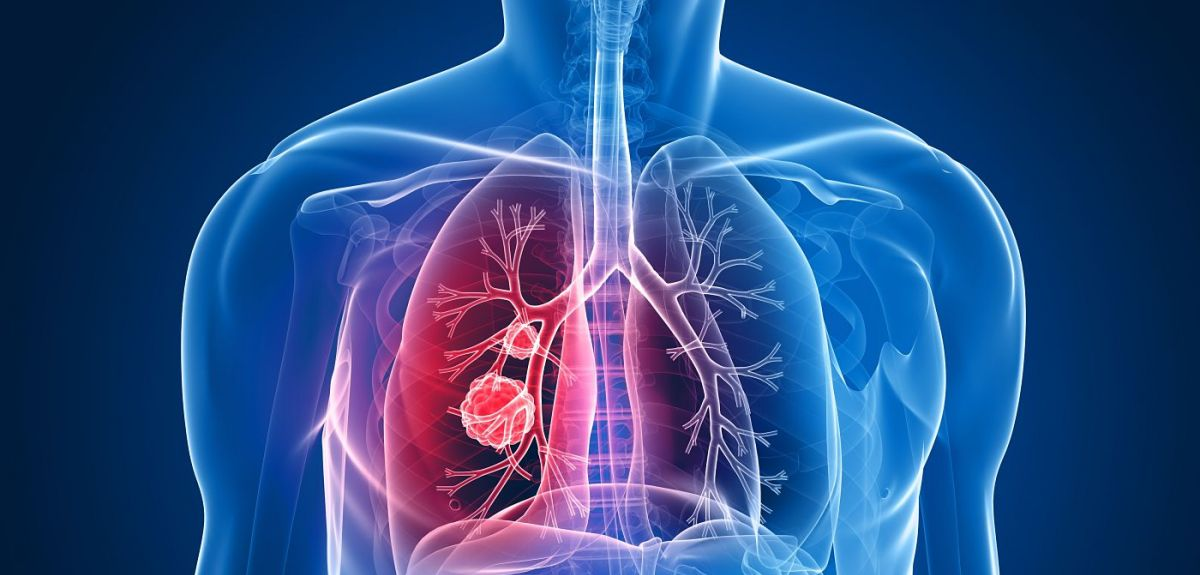

**Dataset :** https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images/data

# 1- Importation des Bibliothéques

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf #feha toutes les modeles

# 2-Importation de Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=("/content/drive/MyDrive/archive")

In [ ]:
train_path_str = '/content/drive/MyDrive/archive/Data/train'

In [ ]:
val_path_str = '/content/drive/MyDrive/archive/Data/valid'

In [ ]:
test_path_str = '/content/drive/MyDrive/archive/Data/test'

In [ ]:
import os #bch tlisti yaani ta9ra les classes eli mawjoudin f test
test_classes = os.listdir(test_path_str)

# **3- *Preprocessing* Data**

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, Dropout
#Conv2D: couche de convolution 2D pour extraire des caractéristiques des images
#Dense: couche de cnx
#MaxPooling2D: couche de sous échantionnage qui réduit les dimentions
#Flatten: couche qui aplatit les données en entrées en un vecteur
#BatchNormalization: couche qui normalise les activations de la couche précédente

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16 #extraction des caractéristiques
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input

import matplotlib.pyplot as plt
import cv2 as cv

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle # Import shuffle from sklearn.utils

from keras.utils import to_categorical

In [ ]:
#def de la forme des entrées de model
input_shape =(224, 224,3) #les images sont 224*224 pixels avec 3 canaux de couleur RGB

In [ ]:
#def de nmbre de classes de sortie
num_classes = 4

In [ ]:
#configuration du generateur d'img pour l'entrainement aves augmentation des données
trainGenerator= ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range= 10,
    width_shift_range=0.3,
    height_shift_range= 0.3,
    shear_range= 0.2,
    zoom_range= 0.1,
    horizontal_flip= True,
    vertical_flip= True,
    dtype='float32'
)

In [ ]:
valGenerator = ImageDataGenerator(
    preprocessing_function = preprocess_input,

    dtype= 'float32'
)

In [ ]:
testGenerator = ImageDataGenerator(
    preprocessing_function = preprocess_input,

    dtype= 'float32'
)


In [ ]:
train_data = trainGenerator.flow_from_directory(
    train_path_str,
    target_size = (224,224) ,
    batch_size = 16,
    class_mode = 'categorical'
)

Found 625 images belonging to 4 classes.


In [ ]:
val_data = valGenerator.flow_from_directory(
    val_path_str,
    target_size = (224,224) ,
    batch_size = 16,
    class_mode = 'categorical'
)

Found 81 images belonging to 4 classes.


In [ ]:
test_data = testGenerator.flow_from_directory(
    test_path_str,
    target_size = (224,224) ,
    batch_size = 16,
    class_mode = 'categorical'
)

Found 321 images belonging to 4 classes.


In [ ]:
VGG16_model = VGG16 (
    include_top = False, #ne pas inclure les couches de classifications final
    weights = "imagenet", #utiliser les poids pré-entrainer sur le dataset
    input_shape = input_shape
)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
for layer in VGG16_model.layers:
  layer.trainable = False

# **4- Création de Modéle**

In [ ]:
from keras import activations
#création d'un modele sequentiel
model = Sequential()

#ajout de modele VGG pré-entrainé sans la couche fully connected
model.add(VGG16_model)

#ajouter une couche de normalization par lots pour améliorer la stabilité et la vitesse
model.add(BatchNormalization())

#ajouter une couche de pooling max pour réduire la dimentiondes données
model.add(MaxPooling2D((2,2)))

#preparer les données à l'entrée pour fully connected
model.add(Flatten())

#premiere couche fully connected avec 1024 neurones activés par la fonction Relu
model.add(Dense(1024, activation='relu'))

model.add(Dropout(0.3)) #ajout d'une couche de régularisation avec un taux 30%

#deuxieme couche fully connected avec 512 neurones activés par la fonction Relu
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))

#couche de sortie avec un nombre des neurones de classes activée par softmax
model.add(Dense(num_classes, activation='softmax'))

model.summary() #affichage de model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 batch_normalization (Batch  (None, 7, 7, 512)         2048      
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 3, 3, 512)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 1024)              4719616   
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [ ]:
callback= [
    tf.keras.callbacks.EarlyStopping(patience=5),  # Arrête l'entraînement si la métrique surveillée ne s'améliore plus après 5 epochs
    tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only = True), #sauvegarder le model dans un fichier h5
    tf.keras.callbacks.TensorBoard(log_dir='log') #Enregistre les logs pour visualiser les métriques d'entraînement dans TensorBoard
]

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Add accuracy metric

# Fit the model
resultat = model.fit(train_data, validation_data = val_data, epochs=80, verbose=1)

# Evaluate the model
loss, acc = model.evaluate(test_data,verbose = 1) # Now it should return loss and accuracy

Epoch 1/80
40/40 [==============================] - 19s 358ms/step - loss: 0.2332 - accuracy: 0.9280 - val_loss: 0.8157 - val_accuracy: 0.8519
Epoch 2/80
40/40 [==============================] - 17s 415ms/step - loss: 0.3065 - accuracy: 0.8816 - val_loss: 0.6457 - val_accuracy: 0.8642
Epoch 3/80
40/40 [==============================] - 14s 360ms/step - loss: 0.2692 - accuracy: 0.8992 - val_loss: 0.8569 - val_accuracy: 0.8519
Epoch 4/80
40/40 [==============================] - 14s 361ms/step - loss: 0.3846 - accuracy: 0.8848 - val_loss: 0.9430 - val_accuracy: 0.7778
Epoch 5/80
40/40 [==============================] - 15s 365ms/step - loss: 0.3193 - accuracy: 0.8816 - val_loss: 0.8685 - val_accuracy: 0.8148
Epoch 6/80
40/40 [==============================] - 14s 363ms/step - loss: 0.3219 - accuracy: 0.8960 - val_loss: 0.8081 - val_accuracy: 0.8519
Epoch 7/80
40/40 [==============================] - 17s 425ms/step - loss: 0.2840 - accuracy: 0.8928 - val_loss: 0.5913 - val_accuracy: 0.8642

In [ ]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)

21/21 [==============================] - 4s 190ms/step
              precision    recall  f1-score   support

           0       0.36      0.40      0.38       120
           1       0.22      0.25      0.24        51
           2       0.15      0.15      0.15        60
           3       0.39      0.31      0.35        90

    accuracy                           0.31       321
   macro avg       0.28      0.28      0.28       321
weighted avg       0.31      0.31      0.31       321

